In [1]:
import numpy as np

import analyze_control as ac

# 熱源機風量推定のための仮熱負荷

#### 暖房

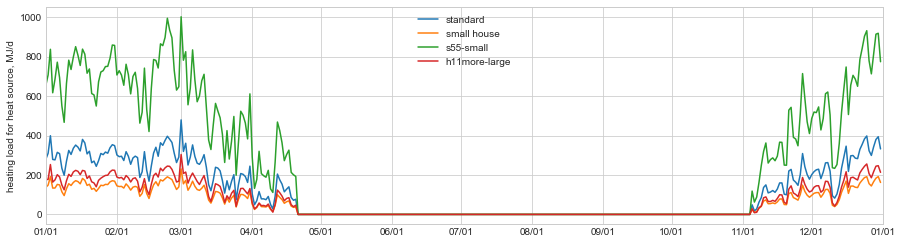

In [2]:
data = [
    (ac.get_main_value(6)['time_value']['output_of_heat_source_for_supply_air_volume_estimation_heating'], 'standard'),
    (ac.get_main_value(10)['time_value']['output_of_heat_source_for_supply_air_volume_estimation_heating'], 'small house'),
    (ac.get_main_value(24)['time_value']['output_of_heat_source_for_supply_air_volume_estimation_heating'], 's55-small'),
    (ac.get_main_value(35)['time_value']['output_of_heat_source_for_supply_air_volume_estimation_heating'], 'h11more-large'),
]

ac.draw_graph('heating load for heat source, MJ/d', data, op='itg')

#### 冷房

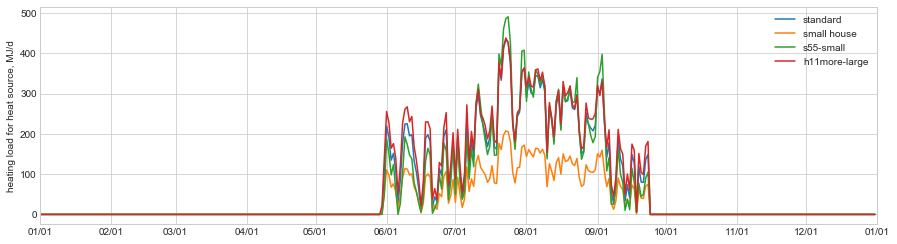

In [3]:
data = [
    (ac.get_main_value(6)['time_value']['output_of_heat_source_for_supply_air_volume_estimation_cooling'], 'standard'),
    (ac.get_main_value(10)['time_value']['output_of_heat_source_for_supply_air_volume_estimation_cooling'], 'small house'),
    (ac.get_main_value(24)['time_value']['output_of_heat_source_for_supply_air_volume_estimation_cooling'], 's55-small'),
    (ac.get_main_value(35)['time_value']['output_of_heat_source_for_supply_air_volume_estimation_cooling'], 'h11more-large'),
]

ac.draw_graph('heating load for heat source, MJ/d', data, op='itg')

# 旧負荷(12室)との比較

この比較に特に意味は無いが、12室負荷計算と、Q値・μ値に基づく推定負荷とのオーダー感が一致しているかを確認する。  
冷房負荷は全熱負荷で比較。

#### 暖房

標準住宅

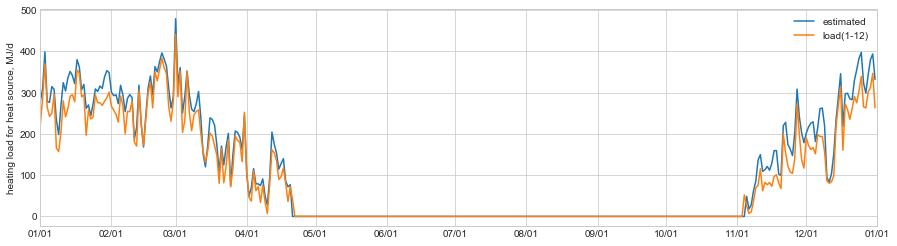

In [4]:
result = ac.get_main_value(6)
data = [
    (result['time_value']['output_of_heat_source_for_supply_air_volume_estimation_heating'], 'estimated'),
    (result['time_value']['old_heating_load_sum_of_12_rooms'], 'load(1-12)'),
]
ac.draw_graph('heating load for heat source, MJ/d', data, op='itg')

狭小住宅

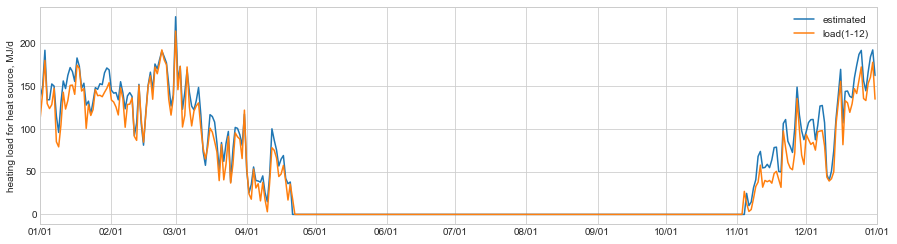

In [5]:
result = ac.get_main_value(10)
data = [
    (result['time_value']['output_of_heat_source_for_supply_air_volume_estimation_heating'], 'estimated'),
    (result['time_value']['old_heating_load_sum_of_12_rooms'], 'load(1-12)'),
]
ac.draw_graph('heating load for heat source, MJ/d', data, op='itg')

S55 Solar:Small

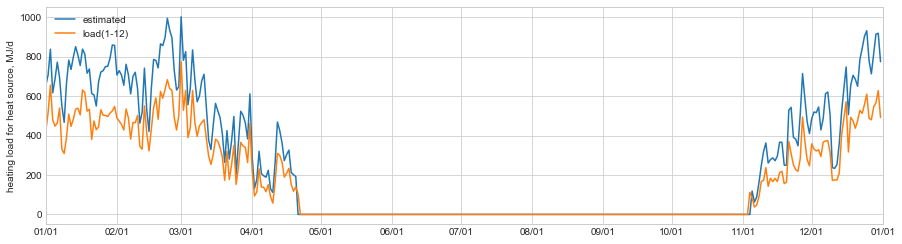

In [6]:
result = ac.get_main_value(24)
data = [
    (result['time_value']['output_of_heat_source_for_supply_air_volume_estimation_heating'], 'estimated'),
    (result['time_value']['old_heating_load_sum_of_12_rooms'], 'load(1-12)'),
]
ac.draw_graph('heating load for heat source, MJ/d', data, op='itg')

h11more Solar:large

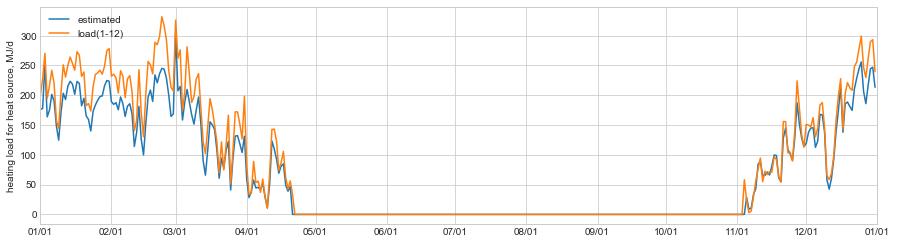

In [7]:
result = ac.get_main_value(35)
data = [
    (result['time_value']['output_of_heat_source_for_supply_air_volume_estimation_heating'], 'estimated'),
    (result['time_value']['old_heating_load_sum_of_12_rooms'], 'load(1-12)'),
]
ac.draw_graph('heating load for heat source, MJ/d', data, op='itg')

#### 冷房

標準住宅

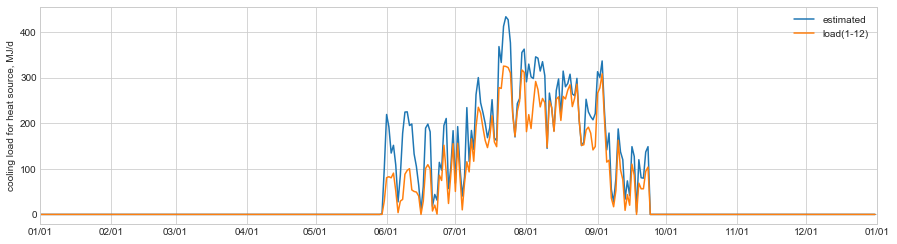

In [8]:
result = ac.get_main_value(6)
data = [
    (result['time_value']['output_of_heat_source_for_supply_air_volume_estimation_cooling'], 'estimated'),
    (result['time_value']['old_sensible_cooling_load_sum_of_12_rooms']
     + result['time_value']['old_latent_cooling_load_sum_of_12_rooms'], 'load(1-12)'),
]
ac.draw_graph('cooling load for heat source, MJ/d', data, op='itg')

狭小住宅

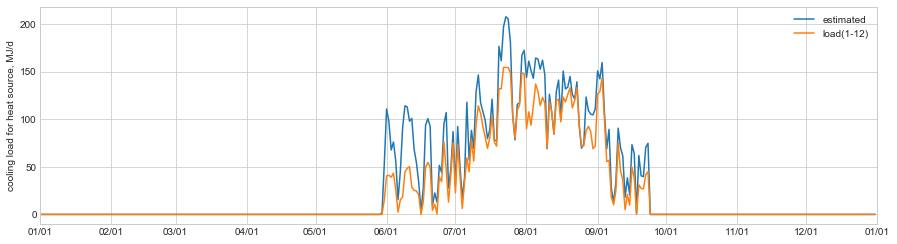

In [9]:
result = ac.get_main_value(10)
data = [
    (result['time_value']['output_of_heat_source_for_supply_air_volume_estimation_cooling'], 'estimated'),
    (result['time_value']['old_sensible_cooling_load_sum_of_12_rooms']
     + result['time_value']['old_latent_cooling_load_sum_of_12_rooms'], 'load(1-12)'),
]
ac.draw_graph('cooling load for heat source, MJ/d', data, op='itg')

S55 Solar:Small

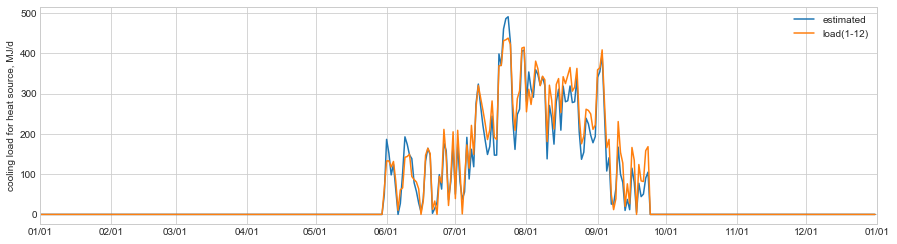

In [10]:
result = ac.get_main_value(24)
data = [
    (result['time_value']['output_of_heat_source_for_supply_air_volume_estimation_cooling'], 'estimated'),
    (result['time_value']['old_sensible_cooling_load_sum_of_12_rooms']
     + result['time_value']['old_latent_cooling_load_sum_of_12_rooms'], 'load(1-12)'),
]
ac.draw_graph('cooling load for heat source, MJ/d', data, op='itg')

h11more Solar:large

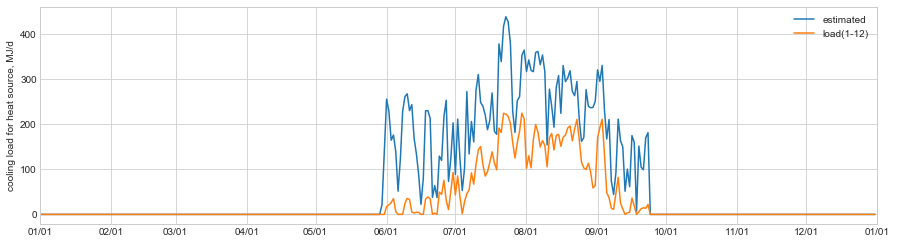

In [11]:
result = ac.get_main_value(35)
data = [
    (result['time_value']['output_of_heat_source_for_supply_air_volume_estimation_cooling'], 'estimated'),
    (result['time_value']['old_sensible_cooling_load_sum_of_12_rooms']
     + result['time_value']['old_latent_cooling_load_sum_of_12_rooms'], 'load(1-12)'),
]
ac.draw_graph('cooling load for heat source, MJ/d', data, op='itg')

# 熱源機風量

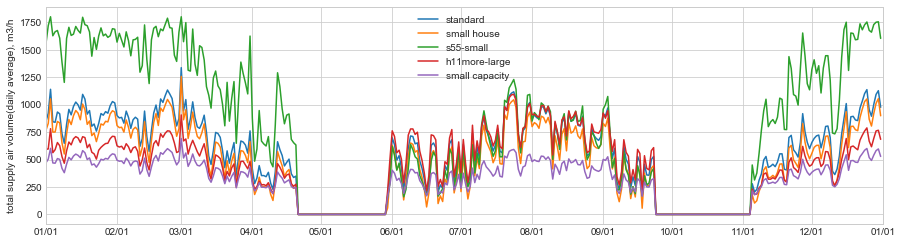

In [12]:
data = [
    (ac.get_main_value(6)['time_value']['supply_air_volume_of_heat_source'], 'standard'),
    (ac.get_main_value(10)['time_value']['supply_air_volume_of_heat_source'], 'small house'),
    (ac.get_main_value(24)['time_value']['supply_air_volume_of_heat_source'], 's55-small'),
    (ac.get_main_value(35)['time_value']['supply_air_volume_of_heat_source'], 'h11more-large'),
    (ac.get_main_value(49)['time_value']['supply_air_volume_of_heat_source'], 'small capacity'),
]

ac.draw_graph('total supply air volume(daily average), m3/h', data, op='ave')

# 各室の吹き出し風量

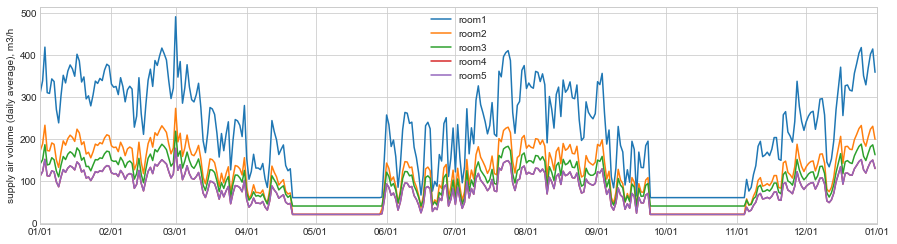

In [13]:
result = ac.get_main_value(6)
data = [
    (result['time_value']['supply_air_volume_room1'], 'room1'),
    (result['time_value']['supply_air_volume_room2'], 'room2'),
    (result['time_value']['supply_air_volume_room3'], 'room3'),
    (result['time_value']['supply_air_volume_room4'], 'room4'),
    (result['time_value']['supply_air_volume_room5'], 'room5'),
]

ac.draw_graph('supply air volume (daily average), m3/h', data, op='ave')